In [1]:
#import some things we will need
import pandas as pd
import glob
from astropy.io import ascii
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import alipy

# Gather Photometric Zero Points
On 'Photometric' nights, the observer takes data of Landolt stars. The magnitude of these stars is very will known. We can use the observations of these stars to calibrate the true magnitude of other stars that were observed on the same night.

Eventually, we would like to calibrate the stars we will use as comparison stars in the Nova Musca field. To do this, we will first need the zero points which have been calculated from previous observations of Landolt Stars

In [2]:
suzpts=glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.200[6-9]_*')+glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.201[0-1]_*') + glob.glob('/home/ih64/Desktop/PhotResults/RESULTS.2012_0[0-6]')

rowdict={'date':[], 'star':[], 'b':[], 'v':[],'r':[],'i':[],
	'cb':[],'cv':[],'cr':[],'ci':[],
	'xb':[],'xv':[],'xr':[],'xi':[]}

headerdelim='======================================================================================================================='

for month in suzpts:
	#they're not super machine-readable-friendly, we have to take them apart and yank out what we need
	with open(month,'r') as f:
		text=f.read()

	#header info is in the first two sections above the delimiter
	data=text.split(headerdelim)[2]

	#each date is broken up by a long string of hyphens
	dates=data.split('-----------------------------------------------------------------------------------------------------------------------')

	#go up to the second to last element in the list dates, the last one is just an empty string
	for day in dates[0:-2]:
		words=day.strip().split()
		if words[0][0:2]=='20':
			rowdict['date'].append(float(words[0][2:]))
			rowdict['star'].append(words[1])
			rowdict['b'].append(words[2])
			rowdict['v'].append(words[3])
			rowdict['r'].append(words[4])
			rowdict['i'].append(words[5])
			rowdict['xb'].append(words[6])
			rowdict['xv'].append(words[7])
			rowdict['xr'].append(words[8])
			rowdict['xi'].append(words[9])
			rowdict['cb'].append(words[10])
			rowdict['cv'].append(words[11])
			rowdict['cr'].append(words[12])
			rowdict['ci'].append(words[13])

#shove all the data into a pandas dataframe
table=pd.DataFrame(rowdict)
#force the datatype for the dates to be ints, they were made from strings to floats above
table['date']=table['date'].values.flatten().astype(int)
#the mirror was cleaned on 110921, this note sneaks in and screws up the data frame
table=table.drop(table[table['date']==110921].index)
#suzane filled in the string 'na' if the data was not determined. change these to np NaNs in our dataframe
table=table.replace('na',np.nan)
#sometimes the string '---' was used if the data were not determined, swap these out for nans too
table=table.replace('---',np.nan)
table=table.replace('----',np.nan)
#finally, sometimes 0.0 were used if the data were not determined
table=table.replace(0.0,np.nan)
#foce the datatype for the values to floats, they are currently strings.
table[['b','v','r','i','xb','xv','xr','xi','cb','cv','cr','ci']]=table[['b','v','r','i','xb','xv','xr','xi','cb','cv','cr','ci']].astype(float)
table.to_pickle('suzpts')
table.to_csv('suzpts.csv')

In [64]:
#read in the zero points for a few months from 2012 into pandas data frames
augdeczp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2012-08-12.txt',
                     sep='\s+',skiprows=1,names=['date', 'JulianDate', 'star',
                                      'b', 'v', 'r', 'i',
                                      'xb', 'xv', 'xr', 'xi',
                                      'cb', 'cv', 'cr', 'ci'])

In [65]:
#read in the zero points for different months from 2013 into pandas data frames
#the formatting is different for 2013. But it will be useful to have a mix
#of zero points from both years. Aug-Dec 2012 and Jan-May 2013 use different landolt stars
#using both to calibrate the nova musca field can help avoid any systematic errors
#associated with only 1 landolt field

janzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_01.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

febzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_02.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

marzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_03.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

aprzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_04.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

mayzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_05.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

In [66]:
#now stack all the data frames into one data frame so we have all the data in one place
#doing the inner join gets rid of the 'juliandate' column in the augdec table. the other tables do not have this column

zpts=pd.concat([augdeczp,janzp,febzp,marzp,aprzp,mayzp], join='inner')

#now lets save this table
zpts.to_pickle('zptsTable')

# Align Nova Musca Images
In the I and V directories there are the respective I and V band observations of Nova Musca. We would like to make sure all these images are mutually aligned. This way it will be very easy to do aperature photometry in one shot on all of them.

I got all the Nova Musca images I could get my hands on. Some of them come from the directory /data/yalo180/yalo/SMARTS13m/CCD/ccdNovaMusca and the rest from /net/xrb/ccd/reduced. There are ~200 images for each band at this point. However, I had to go through and inspect images by eye to remove any weird-os. Some look like they have bad flat fielding, poor seeing, bad weather, or other anomolies. These were removed.

To align the images, we will rely on a package called 'alipy' someone else wrote. you can see the tutorial and learn more about alipy here http://obswww.unige.ch/~tewes/alipy/tutorial.html

In [ ]:
#align the vband images. the reference image was chosen b.c. the seeing conditions were pretty good that night

images_to_align = sorted(glob.glob("fitsimages/Vband/*.fits"))
ref_image = "fitsimages/Vband/rccd150205.0049.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

In [ ]:
#align the iband images. the ref image was chosen bc the seeing was pretty good that night

images_to_align = sorted(glob.glob("fitsimages/Iband/*.fits"))
ref_image = "fitsimages/Iband/rccd150205.0048.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

The aligning routine outputs the aligned images to the directory /home/ih64/NovaMusca/alipy_out. I renamed and moved the directories to /home/ih64/NovaMusca/fitsimages/Iband_aligned and /home/ih64/NovaMusca/fitsimages/Vband_aligned. There's some way to make it directly output to that path, but i didn't read through the documentation for this code to figure it out and just did it by hand. 

# Batch Photometry
now that our images are aligned, we can find the coordinates for the comparison stars on the finding chart, and use them to do aperture photometry quickly for all the images. I did this in IRAF, and try to keep an outline of the workflow below

cd /home/ih64/Desktop/NovaMusca/fitsimages/Iband_aligned

ecl>imexamine rccd150205.0049_gregister.fits logfile='coords.lis' keeplog+

*now the blinking cursor will appear over the image. hover the cursor over nova musc and press 'x' on the keyboard. this will mark the x,y pixel coordinates of the star in the file 'coords.lis' repeat for all comparison stars. when you are done, press q and the iraf prompt will return in your terminal and the blinking cursor will disaprear*

ecl>ls rccd*fits >> images.lis

ecl> epar phot

make sure you turn off interactive mode, and for images use @images.lis. use the settings susane describes here http://www.ctio.noao.edu/noao/content/13-m-smarts-photometric-calibrations-bvri

phot(image="@images.lis",fwhmpsf=5,datamin=-500.,datamax=30000.,readnoise=6.5,epadu=2.3,exposur="EXPTIME",airmass="SECZ",obstime="JD",filter="CCDFLTID",annulus=25,dannulu=7,apertur="9",verify-,output="default",coords="coords.lis")


then do this process in the Vband_align directory too. you will have a bunch of .mag.1 files which have the photometry.

In [2]:
from astropy.io import ascii

magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Iband_align/rccd*.mag.1')

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'mag7':[],'mag8':[],'mag9':[],'mag10':[],
         'mag11':[],'mag12':[],'mag13':[],'mag14':[],'mag15':[],'mag16':[],
         'mag17':[],'mag18':[],'mag19':[],'mag20':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[],
         'merr7':[],'merr8':[],'merr9':[],'merr10':[],
         'merr11':[],'merr12':[],'merr13':[],'merr14':[],'merr15':[],'merr16':[],
         'merr17':[],'merr18':[],'merr19':[],'merr20':[]}
for i in magfiles:
    photdata=ascii.read(i)
    if np.ma.is_masked(photdata['MAG']):
        photdata['MAG'][photdata['MAG'].mask]=np.nan
    if np.ma.is_masked(photdata['MERR']):
        photdata['MERR'][photdata['MERR'].mask]=np.nan
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(float(photdata['IMAGE'][0][4:10]))
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['mag7'].append(photdata['MAG'][6])
    rowdict['mag8'].append(photdata['MAG'][7])
    rowdict['mag9'].append(photdata['MAG'][8])
    rowdict['mag10'].append(photdata['MAG'][9])
    rowdict['mag11'].append(photdata['MAG'][10])
    rowdict['mag12'].append(photdata['MAG'][11])
    rowdict['mag13'].append(photdata['MAG'][12])
    rowdict['mag14'].append(photdata['MAG'][13])
    rowdict['mag15'].append(photdata['MAG'][14])
    rowdict['mag16'].append(photdata['MAG'][15])
    rowdict['mag17'].append(photdata['MAG'][16])
    rowdict['mag18'].append(photdata['MAG'][17])
    rowdict['mag19'].append(photdata['MAG'][18])
    rowdict['mag20'].append(photdata['MAG'][19])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])
    rowdict['merr7'].append(photdata['MERR'][6])
    rowdict['merr8'].append(photdata['MERR'][7])
    rowdict['merr9'].append(photdata['MERR'][8])
    rowdict['merr10'].append(photdata['MERR'][9])
    rowdict['merr11'].append(photdata['MERR'][10])
    rowdict['merr12'].append(photdata['MERR'][11])
    rowdict['merr13'].append(photdata['MERR'][12])
    rowdict['merr14'].append(photdata['MERR'][13])
    rowdict['merr15'].append(photdata['MERR'][14])
    rowdict['merr16'].append(photdata['MERR'][15])
    rowdict['merr17'].append(photdata['MERR'][16])
    rowdict['merr18'].append(photdata['MERR'][17])
    rowdict['merr19'].append(photdata['MERR'][18])
    rowdict['merr20'].append(photdata['MERR'][19])

In [3]:
photITable=pd.DataFrame(rowdict)

In [4]:
#change the data type of the date column to int. cant translate from string to int above for some reason
photITable['date']=photITable['date'].astype(int)

In [5]:
#notice a weird value for the julian date snuck in. the header must have not written correctly
photITable[photITable['juliandate']=='040512  10.7']

,airmass,date,fname,juliandate,mag1,mag10,mag11,mag12,mag13,mag14,...,merr19,merr2,merr20,merr3,merr4,merr5,merr6,merr7,merr8,merr9
479,--,40511,rccd040511.0037_gregist,040512 10.7,21.955,18.289,NaN,17.157,17.614,17.887,...,0.003,0.001,0.008,0.002,0.003,0.013,0.001,0.001,0.003,0.002


In [6]:
#lets just drop this row
photITable=photITable.drop(479)
#now lets save this table
photITable.to_pickle('photITable')
photITable.to_csv('photITable.csv')

In [7]:
#same thing for V band
magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Vband_align/rccd*.mag.1')

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'mag7':[],'mag8':[],'mag9':[],'mag10':[],
         'mag11':[],'mag12':[],'mag13':[],'mag14':[],'mag15':[],'mag16':[],
         'mag17':[],'mag18':[],'mag19':[],'mag20':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[],
         'merr7':[],'merr8':[],'merr9':[],'merr10':[],
         'merr11':[],'merr12':[],'merr13':[],'merr14':[],'merr15':[],'merr16':[],
         'merr17':[],'merr18':[],'merr19':[],'merr20':[]}

for i in magfiles:
    photdata=ascii.read(i)
    if np.ma.is_masked(photdata['MAG']):
        photdata['MAG'][photdata['MAG'].mask]=np.nan
    if np.ma.is_masked(photdata['MERR']):
        photdata['MERR'][photdata['MERR'].mask]=np.nan
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(float(photdata['IMAGE'][0][4:10]))
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['mag7'].append(photdata['MAG'][6])
    rowdict['mag8'].append(photdata['MAG'][7])
    rowdict['mag9'].append(photdata['MAG'][8])
    rowdict['mag10'].append(photdata['MAG'][9])
    rowdict['mag11'].append(photdata['MAG'][10])
    rowdict['mag12'].append(photdata['MAG'][11])
    rowdict['mag13'].append(photdata['MAG'][12])
    rowdict['mag14'].append(photdata['MAG'][13])
    rowdict['mag15'].append(photdata['MAG'][14])
    rowdict['mag16'].append(photdata['MAG'][15])
    rowdict['mag17'].append(photdata['MAG'][16])
    rowdict['mag18'].append(photdata['MAG'][17])
    rowdict['mag19'].append(photdata['MAG'][18])
    rowdict['mag20'].append(photdata['MAG'][19])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])
    rowdict['merr7'].append(photdata['MERR'][6])
    rowdict['merr8'].append(photdata['MERR'][7])
    rowdict['merr9'].append(photdata['MERR'][8])
    rowdict['merr10'].append(photdata['MERR'][9])
    rowdict['merr11'].append(photdata['MERR'][10])
    rowdict['merr12'].append(photdata['MERR'][11])
    rowdict['merr13'].append(photdata['MERR'][12])
    rowdict['merr14'].append(photdata['MERR'][13])
    rowdict['merr15'].append(photdata['MERR'][14])
    rowdict['merr16'].append(photdata['MERR'][15])
    rowdict['merr17'].append(photdata['MERR'][16])
    rowdict['merr18'].append(photdata['MERR'][17])
    rowdict['merr19'].append(photdata['MERR'][18])
    rowdict['merr20'].append(photdata['MERR'][19])

In [8]:
photVTable=pd.DataFrame(rowdict)

In [9]:
#change data type of date to int
photVTable['date']=photVTable['date'].astype(int)
#now lets save this table
photVTable.to_pickle('photVTable')
photVTable.to_csv('photVTable.csv')

# Find True Magnitudes
use the zero points and the instrumental magnitudes we calculated from stars in the Nova Musca field to calculate their true magnitudes

In [10]:
#grab the Iband photometry table, Vband photometry table, and the zeropoints table

suzpts=pd.read_csv('suzpts.csv')
zpts=pd.read_csv('zptsTable.csv')
photVTable=pd.read_csv('photVTable.csv')
photITable=pd.read_csv('photITable.csv')

In [11]:
#stack the tables of suzanes zero points and imrans, only selecting columns w date, star id, and v band info
#then join this to the raw-vband-photometry table on date to make 'masterV'
masterV=pd.merge(pd.concat([suzpts,zpts]).ix[:,['date','star','v','cv','xv']],photVTable, on='date')
#the extinction coef for V was .14 before 200905 and .144 after
def excoefV(date):
    if date < 90500:
        return .14
    else:
        return .144

    #add a column w the right extinction coefficent given the date
masterV['excoefV']=masterV['date'].apply(lambda x: excoefV(x))

#calculate the true magnitude of each star on the photometric dates to make 'photCalV'
photCalV=masterV.ix[:,['date','juliandate']].join(
    masterV.ix[:,['mag1','mag2','mag3','mag4','mag5',
                  'mag6','mag7','mag8','mag9','mag10',
                  'mag11','mag12','mag13','mag14','mag15',
                  'mag16','mag17','mag18','mag19','mag20']].apply(
        lambda x: x - masterV['cv'] - (masterV['airmass']*masterV['excoefV']), axis=0))
photCalV.to_csv('photCalV.csv')

In [12]:
#now do the same for I
masterI=pd.merge(pd.concat([suzpts,zpts]).ix[:,['date','star','i','ci','xi']],photITable, on='date')
#the extinction coef for V was .066 before 200905 and .056 after
def excoefI(date):
    if date < 90500:
        return .066
    else:
        return .056
masterI['excoefI']=masterI['date'].apply(lambda x: excoefI(x))
photCalI=masterI.ix[:,['date','juliandate']].join(
    masterI.ix[:,['mag1','mag2','mag3','mag4','mag5',
                  'mag6','mag7','mag8','mag9','mag10',
                  'mag11','mag12','mag13','mag14','mag15',
                  'mag16','mag17','mag18','mag19','mag20']].apply(
        lambda x: x - masterI['ci'] - (masterI['airmass'].astype(float)*masterI['excoefI']), axis=0))
photCalI.to_csv('photCalI.csv')

In [21]:
#lets look at some summary statistics of the calculated true magnitudes
#notice some values are being dropped. more on that in 2 cells
photCalV.drop([0,1,2,63,70,71,67]).drop(['date','juliandate'], axis=1).describe()

,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,mag9,mag10,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20
count,101.000000,32.000000,101.000000,101.000000,101.000000,72.000000,94.000000,101.000000,101.000000,101.000000,7.000000,23.000000,80.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,20.071599,14.613368,16.715777,17.158609,18.861233,15.096229,15.884011,16.414015,16.466292,15.951114,14.225965,14.451676,14.777734,15.615075,16.043896,15.883817,17.875995,18.602649,16.845084,18.188688
std,0.323658,0.017700,0.020949,0.020346,0.057203,0.016152,0.031239,0.042349,0.018718,0.019720,0.043765,0.056021,0.022454,0.049314,0.035839,0.035127,0.030381,0.043027,0.020987,0.034403
min,19.296240,14.586000,16.667400,17.107400,18.651400,15.057319,15.739000,16.328283,16.421400,15.905400,14.159194,14.368136,14.725240,15.504240,15.961319,15.804319,17.754800,18.419000,16.789000,18.013400
25%,19.832240,14.602250,16.700240,17.144400,18.825000,15.086096,15.871800,16.376502,16.454570,15.937873,14.198581,14.392975,14.763813,15.567670,16.018600,15.848758,17.861600,18.581319,16.832800,18.173000
50%,20.116200,14.613391,16.716400,17.159618,18.863240,15.096768,15.887735,16.425600,16.466400,15.949398,14.247600,14.478600,14.776297,15.632400,16.051000,15.894400,17.879240,18.605400,16.844600,18.188600
75%,20.288800,14.620672,16.729400,17.174362,18.897633,15.110890,15.903300,16.445240,16.480240,15.967800,14.252780,14.499520,14.794118,15.649600,16.072000,15.911000,17.895600,18.631400,16.859600,18.208680
max,21.027000,14.660240,16.767240,17.217000,19.066406,15.133000,15.941758,16.479800,16.505000,15.990000,14.272240,14.517240,14.834240,15.699800,16.110320,15.959200,17.948320,18.741440,16.895240,18.288406


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2afee2d4fcd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2afee44f8050>]], dtype=object)

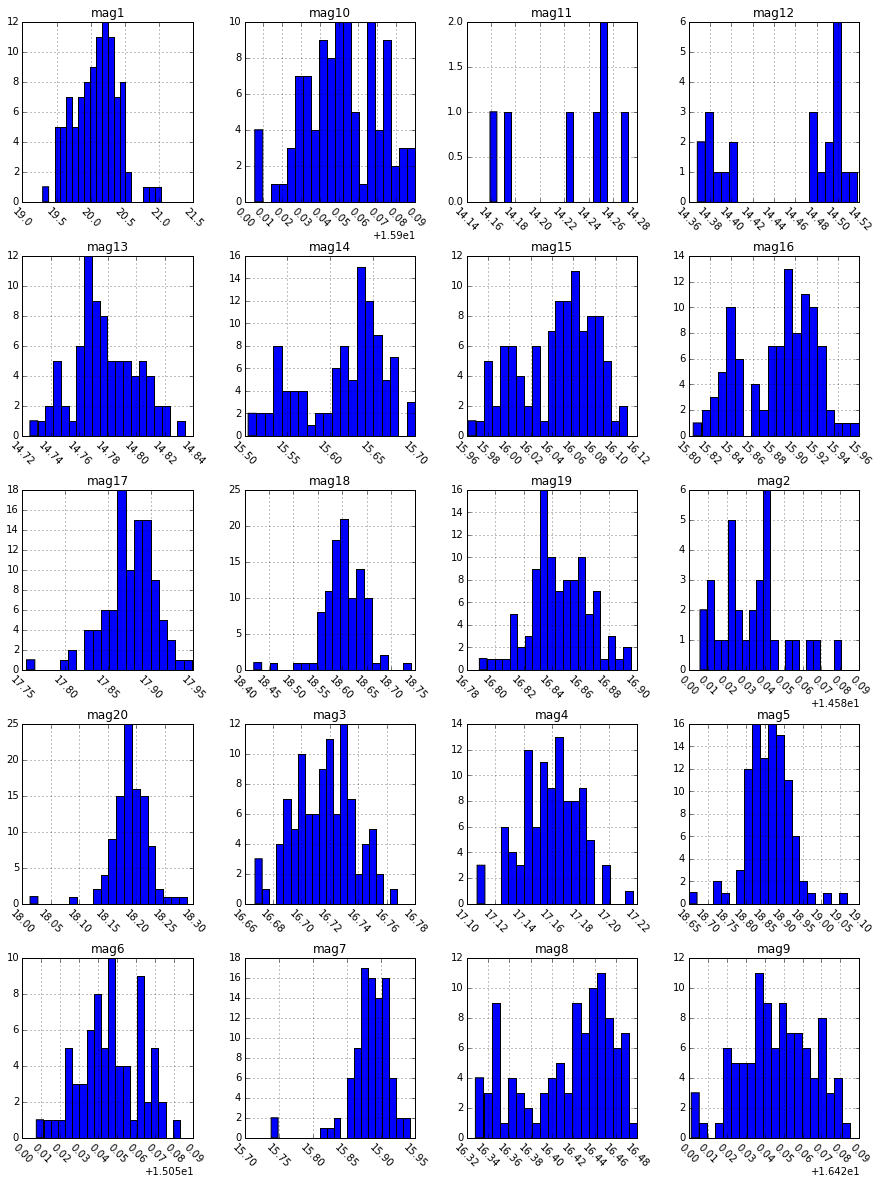

In [22]:
#lets make some histograms of the calculated true magnitudes for each star
#notice that some data points are being dropped. more on that in the cell below
photCalV.drop([0,1,2,63,70,71,67]).drop(['date','juliandate'], axis=1).hist(figsize=(15,20),bins=20,xrot=-45)

In [20]:
#there are some points which are very unusual for the distributions. they are shown here for completness,
#and have been dropped from the histograms and calculations above
pd.concat([photCalV[photCalV['mag5'] < 18.6],photCalV[photCalV['mag16'] > 16.0],photCalV[photCalV['mag10'] > 30.0],
           photCalV[photCalV['mag16'] > 16.0],photCalV[photCalV['mag9'] > 16.6],photCalV[photCalV['mag7'] < 15.6]])

,date,juliandate,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,...,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20
2,60110,2453746.81446,19.5496,NaN,16.1846,16.6296,18.2856,14.5516,15.3426,15.9026,...,NaN,NaN,14.2466,15.0906,15.5256,15.3596,17.3526,18.0766,16.3116,17.6586
1,60109,2453745.81161,20.4092,NaN,16.8522,17.2992,18.9682,15.2282,16.0142,16.5522,...,NaN,NaN,14.9172,15.7612,16.1732,16.0012,17.9702,18.7472,16.9812,18.3032
63,90219,2454882.76816,20.6968,NaN,16.9818,17.4338,19.1538,15.3678,16.1818,16.7368,...,NaN,NaN,15.0498,15.9208,16.1348,24.6278,18.1478,18.8808,17.1048,18.4468
70,90416,2454938.67846,19.9204,14.7174,16.8234,17.2674,18.9664,15.1974,NaN,16.5114,...,NaN,14.5884,14.9024,15.7574,16.1544,16.0074,18.0074,18.7344,16.9514,18.2944
71,90418,2454940.61659,19.7704,14.7474,16.8534,17.2964,19.0274,15.2284,15.7114,16.5614,...,NaN,14.6234,14.9304,15.7774,16.2064,16.0634,18.0174,18.7854,16.9854,18.3254
67,90407,2454929.67103,19.9020,NaN,16.7380,17.1860,18.9240,NaN,NaN,16.4280,...,NaN,NaN,NaN,15.6640,16.0560,15.9280,17.9110,18.6440,16.8740,18.2730
1,60109,2453745.81161,20.4092,NaN,16.8522,17.2992,18.9682,15.2282,16.0142,16.5522,...,NaN,NaN,14.9172,15.7612,16.1732,16.0012,17.9702,18.7472,16.9812,18.3032
63,90219,2454882.76816,20.6968,NaN,16.9818,17.4338,19.1538,15.3678,16.1818,16.7368,...,NaN,NaN,15.0498,15.9208,16.1348,24.6278,18.1478,18.8808,17.1048,18.4468
70,90416,2454938.67846,19.9204,14.7174,16.8234,17.2674,18.9664,15.1974,NaN,16.5114,...,NaN,14.5884,14.9024,15.7574,16.1544,16.0074,18.0074,18.7344,16.9514,18.2944
71,90418,2454940.61659,19.7704,14.7474,16.8534,17.2964,19.0274,15.2284,15.7114,16.5614,...,NaN,14.6234,14.9304,15.7774,16.2064,16.0634,18.0174,18.7854,16.9854,18.3254


In [29]:
#now some summary statistics for the I band
photCalI.drop([0,2,8,67,70]).drop(['date','juliandate'],axis=1).describe()

,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,mag9,mag10,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20
count,110.000000,14.000000,110.000000,110.000000,110.000000,49.000000,97.000000,110.000000,110.000000,102.000000,1.000000,5.000000,79.000000,80.000000,109.000000,100.000000,110.000000,110.000000,110.000000,110.000000
mean,18.478743,13.727000,15.304070,15.799925,17.705425,14.139993,14.689718,15.449125,15.504643,14.662013,12.933445,13.473028,13.973758,14.212740,15.072355,14.568193,16.848598,17.335770,15.815325,16.800334
std,0.237172,0.027441,0.037113,0.038476,0.067128,0.027286,0.208365,0.051114,0.038590,0.042418,NaN,0.056930,0.038986,0.065626,0.040403,0.044766,0.044874,0.052056,0.037851,0.043166
min,17.010445,13.687025,15.198020,15.710020,17.558540,14.084245,12.716420,15.343245,15.418020,14.516420,12.933445,13.387025,13.893245,14.065245,14.966245,14.458245,16.720860,17.208880,15.722020,16.685520
25%,18.356337,13.714039,15.283935,15.780530,17.657690,14.122025,14.693960,15.414460,15.484860,14.642970,12.933445,13.442310,13.951520,14.172244,15.047420,14.533999,16.825038,17.310455,15.793578,16.776891
50%,18.505700,13.722773,15.301210,15.796250,17.697045,14.137860,14.709520,15.455040,15.502018,14.659098,12.933445,13.508000,13.971300,14.231740,15.076520,14.580740,16.844690,17.332837,15.811420,16.798743
75%,18.639807,13.738908,15.314792,15.811725,17.755042,14.154440,14.723647,15.477455,15.517283,14.674415,12.933445,13.508445,13.983820,14.244710,15.097200,14.598690,16.866515,17.361473,15.830702,16.817718
max,18.944520,13.795445,15.509520,16.005520,17.895445,14.224889,14.894520,15.687520,15.731520,14.891520,12.933445,13.519360,14.172520,14.450520,15.199220,14.684220,17.044520,17.540520,16.005520,16.979520


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2afee7115ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2afeec4c3ad0>]], dtype=object)

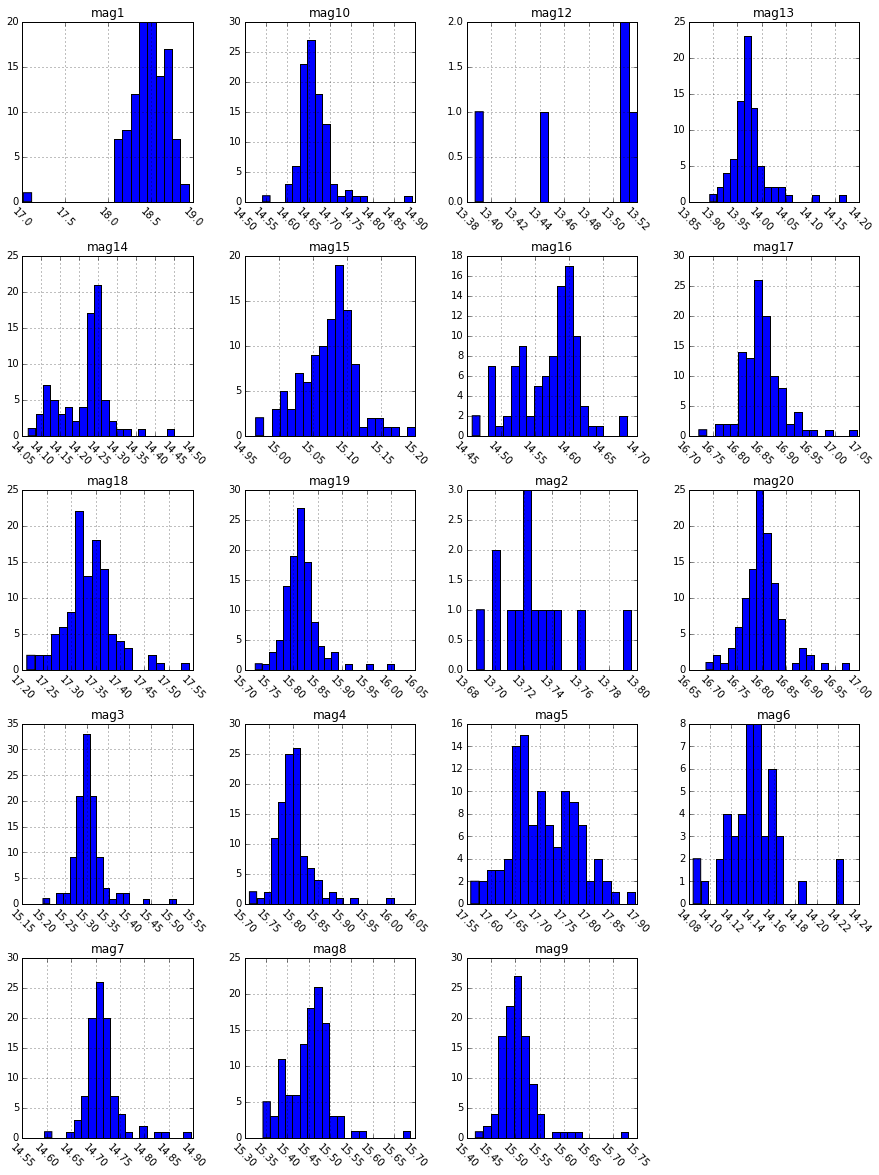

In [31]:
#and some histograms too
photCalI.drop([0,2,8,17,67,70,71]).drop(['date','juliandate','mag11'], axis=1).hist(figsize=(15,20),bins=20,xrot=-45)

In [32]:
#here we list unusual values we dropped
pd.concat([photCalI[photCalI['mag10'] < 14.4],photCalI[photCalI['mag10'] > 30.0],photCalI[photCalI['mag16'] > 19],
           photCalI[photCalI['mag5'] < 17.5],photCalI[photCalI['mag7'] < 14.5],photCalI[photCalI['mag7'] > 16.5]])

,date,juliandate,mag1,mag2,mag3,mag4,mag5,mag6,mag7,mag8,...,mag11,mag12,mag13,mag14,mag15,mag16,mag17,mag18,mag19,mag20
0,80713,2454661.48754,18.92364,NaN,15.29964,15.78264,17.82564,NaN,13.71464,15.46164,...,NaN,NaN,NaN,NaN,15.09864,14.60464,16.85564,17.33864,15.81764,16.81264
2,60110,2453746.80329,17.77088,NaN,14.57388,15.08288,16.94288,NaN,14.00388,14.76688,...,NaN,NaN,NaN,NaN,14.34588,13.89488,16.12488,16.63788,15.11288,16.11288
67,90407,2454929.65996,18.21686,NaN,15.32686,15.82486,17.77486,NaN,NaN,15.45586,...,NaN,NaN,NaN,NaN,15.09286,NaN,16.89086,17.43486,15.84186,16.81186
2,60110,2453746.80329,17.77088,NaN,14.57388,15.08288,16.94288,NaN,14.00388,14.76688,...,NaN,NaN,NaN,NaN,14.34588,13.89488,16.12488,16.63788,15.11288,16.11288
8,60117,2453753.71490,18.85832,NaN,15.28232,15.77632,17.26732,14.11932,14.70232,15.42532,...,NaN,NaN,13.94132,14.21632,15.04132,14.55432,16.88732,17.33132,15.80632,16.78232
0,80713,2454661.48754,18.92364,NaN,15.29964,15.78264,17.82564,NaN,13.71464,15.46164,...,NaN,NaN,NaN,NaN,15.09864,14.60464,16.85564,17.33864,15.81764,16.81264
2,60110,2453746.80329,17.77088,NaN,14.57388,15.08288,16.94288,NaN,14.00388,14.76688,...,NaN,NaN,NaN,NaN,14.34588,13.89488,16.12488,16.63788,15.11288,16.11288
17,60130,2453766.63941,18.41242,NaN,15.28342,15.78142,17.58042,14.11742,12.71642,15.41442,...,NaN,NaN,13.95142,14.20442,15.04742,14.55642,16.78242,17.32442,15.78842,16.78242
71,90418,2454940.60551,18.22652,NaN,15.26252,15.74952,17.67652,14.10452,14.39552,15.41952,...,NaN,NaN,13.94152,14.19152,15.03852,14.54752,16.76252,17.24552,15.77852,16.75052
70,90416,2454938.66739,18.46288,NaN,15.42088,15.92988,17.83988,14.26188,16.99588,15.55988,...,NaN,NaN,14.09488,14.35688,15.18988,14.68988,16.98188,17.52488,15.92388,16.93488


# Calibrating Nova Musca 1991
now we know the true magnitudes of several stars in the nova musca field and their variances. using this, we can calculate ano off set for each night, and apply this offset to nova musca each night, to give a magnitude that are on the standard scales

In [33]:
#load up the photometry tables. remember these are the raw magnitudes, all stuff read in from .mag.1 files
photVTable=pd.read_csv('photVTable.csv')
photITable=pd.read_csv('photITable.csv')

#lets make a seperate table for V and I that will have our calibrated NM magnitudes
#start off by selecting rows from the raw photometry tables
#for V band I like mag3,mag4,mag9,mag,10,mag17,mag19,mag20. give nice range and have lower variances
#I band i like most of the same stars, but also star 5. left it out of V b.c. its variance was kinda high.
#otherwise same story
NMVcal=photVTable.ix[:,['date','juliandate','mag1','mag3','mag4','mag9','mag10','mag17','mag19','mag20','merr1']]
NMIcal=photITable.ix[:,['date','juliandate','mag1','mag3','mag4','mag5','mag9','mag10','mag17','mag19','mag20','merr1']]

#we find the average in the difference between the instrumental magnitudes for these stars
#and their calculated magnitudes on the standard scale. this is the offset we will apply to nova musca
NMVcal['offset']=(NMVcal.ix[:,['mag3','mag4','mag5','mag9','mag10','mag17','mag19','mag20']]
                  -[16.71,17.16,18.86,16.47,15.95,17.88,16.85,18.19]).mean(axis=1)
NMIcal['offset']=(NMIcal.ix[:,['mag3','mag4','mag5','mag9','mag10','mag17','mag19','mag20']]
                  -[15.30,15.80,17.71,15.50,14.66,16.85,15.82,16.80]).mean(axis=1)

#lets record the variance for the hell of it
NMVcal['std']=(NMVcal.ix[:,['mag3','mag4','mag5','mag9','mag10','mag17','mag19','mag20']]
                  -[16.71,17.16,18.86,16.47,15.95,17.88,16.85,18.19]).std(axis=1)
NMIcal['std']=(NMIcal.ix[:,['mag3','mag4','mag5','mag9','mag10','mag17','mag19','mag20']]
                  -[15.30,15.80,17.71,15.50,14.66,16.85,15.82,16.80]).std(axis=1)

#rename the column headers for the raw magnitudes for nova musca, for clarity
NMVcal=NMVcal.rename(columns={'mag1':'NMraw'})
NMIcal=NMIcal.rename(columns={'mag1':'NMraw'})

#finally, lets apply the offset to get the calibrated magnitudes for nova musca in each band
NMVcal['NMcal']=NMVcal['NMraw']-NMVcal['offset']
NMIcal['NMcal']=NMIcal['NMraw']-NMIcal['offset']
NMVcal.to_csv('NMV.csv')
NMIcal.to_csv('NMI.csv')

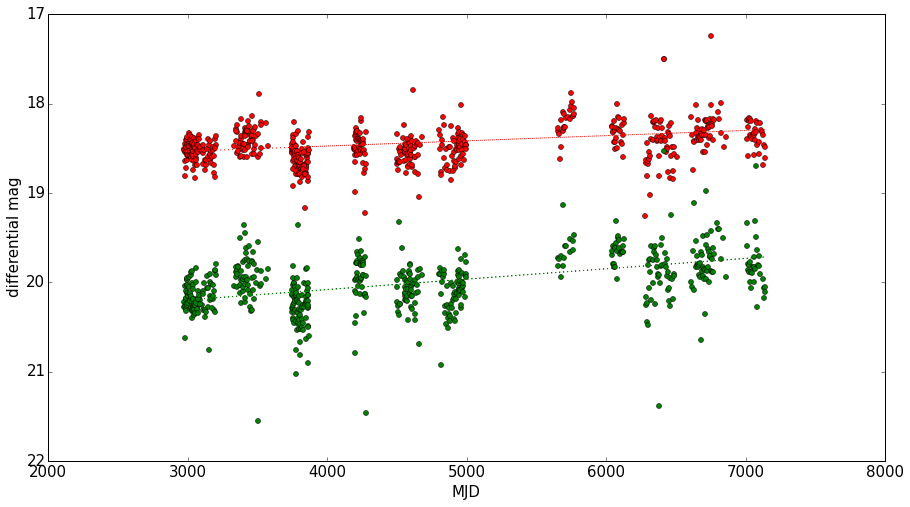

In [34]:
#now lets take a look at our light curve

#use the linear regression model from sklearn, making a model for each I and V band
regVmag=linear_model.LinearRegression()
regImag=linear_model.LinearRegression()

#now we trian the model on our data sets. we have to drop any NaNs, or else the regression algorithm wont work
regVmag.fit(NMVcal.dropna(how='any')['juliandate'].values.reshape(-1,1)
            ,NMVcal.dropna(how='any')['NMcal'].values.reshape(-1,1))
regImag.fit(NMIcal.dropna(how='any')['juliandate'].values.reshape(-1,1),
            NMIcal.dropna(how='any')['NMcal'].values.reshape(-1,1))

fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

#now plot a light curve of the data
ax.plot(NMIcal['juliandate'].values.astype(float)-2450000,NMIcal['NMcal'],'ro',ms=5)
ax.plot(NMVcal['juliandate'].values.astype(float)-2450000,NMVcal['NMcal'],'go',ms=5)

#and also plot the model, using the observation dates as inputs
ax.plot(NMVcal.dropna(how='any')['juliandate'].values.reshape(-1,1).astype(float)-2450000,
        regVmag.predict(NMVcal.dropna(how='any')['juliandate'].values.reshape(-1,1).astype(float)),color='green',linestyle=':')

ax.plot(NMIcal['juliandate'].values.reshape(-1,1).astype(float)-2450000,
        regImag.predict(NMIcal['juliandate'].values.reshape(-1,1).astype(float)),color='red',linestyle=':')

ax.set_xlabel('MJD')
ax.set_ylabel('differential mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)

ax.set_ybound([17,22])
ax.invert_yaxis()
plt.show()

there is kind of a lot of scatter in the light curve. some of it might be from nova musca actually varying in brightness, but some of the points are *really* off the mark. in fact there are some catastrophically terrible data points that are outside of the range here.

I messed around in imexamine a bit, and I was worried that there was some flux contamination from a star that is close to Nova Musca 1991. the wings of the PSF get close and blend together on nights where the seeing isnt great. Lets see if we can quantify this a little better

# Cleaning The Light Curve
as we mentioned above, there is a lot of scatter, some which is probably from 'poor quality data'. we would like to qualitatively identify the 'bad data' here. I used an IRAF task called 'psfmeasure' to measure the full width half max (FWHM), centroids, relative magnitude, and elipticity of comparison stars 3 and 4. I used these two because they are in every frame, bright but not too bright that they saturate, and pretty steady. The output to these is in the files psfmeasureI.out and psfmeasureV.out.

likewsie, I ran psfmeasure on nova musca and the star which is close to it. The outputs are in psfmeasureNMI.out and psfmeasureNMVout. these two stars are very faint, and so while their centroid measurements are probably OK, their FWHM measurments are very poor-giving derastic numbers like 35 pixels etc. The FWHM is better characterized by stars 3 and 4 in the above outputs because they are brighter, and you get more reasonable numbers, typically around 3-3.5 pixels 

so the idea is to measure the FWHM with the comparison stars, and then measure the distance between NM and the potential contaminant, and try to understand how the contamination may be related to the seeing conditions. 

before I did anything in python, I had to work on the psfmeasure output files. they are not formatted in a particlarly machine readable way-or at least not in a way I know. so i used the following unix command

awk '{print"," $1"," $2"," $3"," $4"," $5 "," $6}' psfmeasureINM.out > psfNMI.csv

that way I kept the columns I cared about, and comma delimited them as well

In [2]:
#skip the first two lines because theres some stuff left over from psfmeasure output we dont need
#then skip every other line, because thats the output of the contaminant star, the skip the last few
#because theres some footer info in there
psfINM=pd.read_csv('psfNMI.csv',skiprows=[0,1]+range(2,1218,2)+range(1217,1222),
            names=['blank','Image','Column','Line','Mag','FWHM','Ellip']).drop('blank', axis=1)

In [3]:
#a quick look at the data
psfINM.describe()

,Column,Line,Mag,FWHM,Ellip
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,543.467216,542.010379,1.769835,14.495544,0.520412
std,4.462428,2.788793,1.243397,6.399025,0.220781
min,530.670000,535.090000,-1.420000,0.905000,0.000000
25%,542.005000,540.675000,1.720000,12.729000,0.350000
50%,543.470000,543.180000,2.060000,13.488000,0.520000
75%,544.930000,543.860000,2.410000,14.503000,0.670000
max,560.060000,546.460000,6.280000,32.013000,1.000000


In [4]:
#still skip over the header and footer, and starting from row num 2, skip everyother row. those are NM and 
#we want the contaminant star's data in this dataframe
psfIcont=pd.read_csv('psfNMI.csv',skiprows=[0,1,2]+range(1,1218,2)+range(1217,1222),
                  names=['blank','Column','Line','Mag','FWHM','Ellip','last']).drop(['blank','last'], axis=1)

In [5]:
#have a quick look
psfIcont.describe()

,Column,Line,Mag,FWHM,Ellip
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,549.617792,539.458188,0.769852,14.559242,0.543855
std,5.292747,3.052118,1.374382,5.171285,0.262207
min,534.630000,534.880000,-1.450000,1.611000,0.030000
25%,544.695000,535.370000,-0.745000,12.339000,0.270000
50%,548.830000,540.450000,0.960000,13.248000,0.610000
75%,553.880000,542.340000,2.040000,20.015000,0.780000
max,560.210000,544.730000,4.480000,26.014000,0.910000


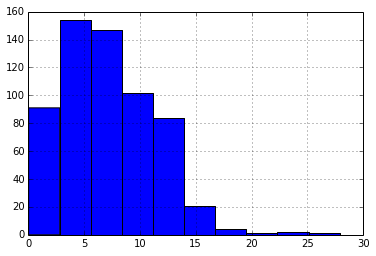

In [6]:
#calculat the difference between the centroids
centDiffI=np.sqrt((psfINM.Column - psfIcont.Column).apply(lambda x: np.square(x)) + (psfINM.Line - psfIcont.Line).apply(lambda x: np.square(x)))
centDiffI.hist()

well ... It turns out this is TERRIBLE! the calculation of the centroid varies *wildly*

The phot task in IRAF uses a centeroid algorithm to find the center of stars when doing photometry. did it do this poorly of a job aslo?

Lets have a closer look at the photometry output to investigate this. In the .mag.1 files which are produced, the feilds 'XSHIFT' and 'YSHIFT' record the distance in pixels that the photometry routine moved from the initial coordinates, which were supplied-in this case-by a coordinate list in the file 'coords.lis.' 

in IRAF, do the following in the {V,Ib}and_align directories

ecl> txdump ***.mag.1 "IMAGE,OTIME,ID,XSHIFT,YSHIFT" yes >> {V,I}xyshift.out



In [48]:
#read in the output of {V,I}xyshift.out to panda data frames so we can do stuff
Vdeltaxy=pd.read_table('Vxyshift.out', names=['image','juliandate','id','xshift','yshift'], sep='\s+')

#lets see if the centroid shifted by more than 2 pixels in either x or y direction for NM
Vdeltaxy[(Vdeltaxy.id == 1) & ((np.abs(Vdeltaxy.xshift) > 3 ) | (np.abs(Vdeltaxy.xshift) > 3))]

,image,juliandate,id,xshift,yshift
4220,rccd060321.0051_gregist,2453816.66211,1,-3.561,-1.509
4520,rccd060424.0028_gregist,2453850.52536,1,-4.204,-3.704
5840,rccd080216.0061_gregist,2454513.74810,1,-6.031,-7.516
7400,rccd090303.0071_gregist,2454894.74770,1,28.922,-10.362
8300,rccd110507.0040_gregist,2455689.60005,1,-4.871,-1.607
9580,rccd130501.0052_gregist,2456414.62466,1,10.861,-5.448
9880,rccd130707.0003_gregist,2456481.49146,1,29.048,-10.524
10000,rccd131201.0094_gregist,2456628.82075,1,3.324,-0.266
10460,rccd140224.0055_gregist,2456713.72541,1,-3.694,4.050


In [49]:
NMVcal=pd.read_csv('NMV.csv')
NMVcal[NMVcal.juliandate.isin(
    Vdeltaxy[(Vdeltaxy.id == 1)
             & ((np.abs(Vdeltaxy.xshift) > 3 ) 
                | (np.abs(Vdeltaxy.xshift) > 3))].juliandate.values)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag9,mag10,mag17,mag19,mag20,offset,std,NMcal
211,211,60321,2453816.66211,23.414,19.842,20.290,19.596,19.078,21.017,19.980,21.316,3.121286,0.019653,20.292714
226,226,60424,2453850.52536,23.144,19.917,20.354,19.664,19.151,21.077,20.035,21.363,3.184429,0.017067,19.959571
292,292,80216,2454513.74810,22.407,19.779,20.194,19.542,19.016,20.935,19.921,21.249,3.052286,0.020361,19.354714
370,370,90303,2454894.74770,18.253,19.748,20.184,19.490,18.979,20.922,19.884,21.219,3.022286,0.020353,15.230714
415,415,110507,2455689.60005,23.741,21.189,21.626,20.925,20.409,22.377,21.282,22.661,4.457000,0.028734,19.284000
500,500,131201,2456628.82075,22.158,19.664,20.099,19.417,18.907,20.841,19.790,21.104,2.936000,0.018974,19.222000
523,523,140224,2456713.72541,22.116,19.750,20.193,19.503,18.911,20.918,19.852,21.219,3.010857,0.045576,19.105143


In [50]:
#read in the output of {V,I}xyshift.out to panda data frames so we can do stuff
Ideltaxy=pd.read_table('Ixyshift.out', names=['image','juliandate','id','xshift','yshift'], sep='\s+')

#lets see if the centroid shifted by more than 2 pixels in either x or y direction for NM
Ideltaxy[(Ideltaxy.id == 1) & ((np.abs(Ideltaxy.xshift) > 3 ) | (np.abs(Ideltaxy.xshift) > 3))]

,image,juliandate,id,xshift,yshift
7100,rccd080628.0036_gregist,2454646.57908,1,3.079,-0.331
7680,rccd090303.0070_gregist,2454894.73664,1,28.944,-10.692
10080,rccd130427.0056_gregist,2456410.69824,1,11.421,-7.149
10100,rccd130501.0051_gregist,2456414.61704,1,4.963,-1.405
10120,rccd130501.0052_gregist,2456414.61704,1,4.963,-1.405
11240,rccd140403.0054_gregist,2456751.62630,1,8.370,-5.581


In [63]:
NMIcal=pd.read_csv('NMI.csv')
NMIcal[NMIcal.juliandate.isin(
    Ideltaxy[(Ideltaxy.id == 1)
             & ((np.abs(Ideltaxy.xshift) > 3 ) 
                | (np.abs(Ideltaxy.xshift) > 3))].juliandate.values)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag5,mag9,mag10,mag17,mag19,mag20,offset,std,NMcal
272,272,80628,2454646.57908,22.123,19.391,19.898,21.762,NaN,84.962,20.936,19.885,20.915,13.547000,25.022198,8.576000
301,301,90303,2454894.73664,17.870,19.300,19.789,21.619,19.484,18.667,20.850,19.808,20.777,3.983000,0.024692,13.887000
421,421,130427,2456410.69824,20.691,19.028,19.558,21.475,19.253,18.421,20.588,19.561,20.563,3.752125,0.018902,16.938875
422,422,130501,2456414.61704,22.602,20.385,20.864,22.820,20.618,19.770,21.809,20.914,21.893,5.080375,0.049324,17.521625
423,423,130501,2456414.61704,22.602,20.385,20.864,22.820,20.618,19.770,21.809,20.914,21.893,5.080375,0.049324,17.521625
479,479,140403,2456751.62630,21.012,19.117,19.613,21.506,19.311,18.469,20.671,19.636,20.615,3.813500,0.011212,17.198500


In [52]:
Ithrowout=NMIcal[NMIcal.juliandate.isin(
    Ideltaxy[(Ideltaxy.id == 1)
             & ((np.abs(Ideltaxy.xshift) > 3 ) 
                | (np.abs(Ideltaxy.xshift) > 3))].juliandate.values)].index

Vthrowout=NMVcal[NMVcal.juliandate.isin(
    Vdeltaxy[(Vdeltaxy.id == 1)
             & ((np.abs(Vdeltaxy.xshift) > 3 ) 
                | (np.abs(Vdeltaxy.xshift) > 3))].juliandate.values)].index

# Scratch space

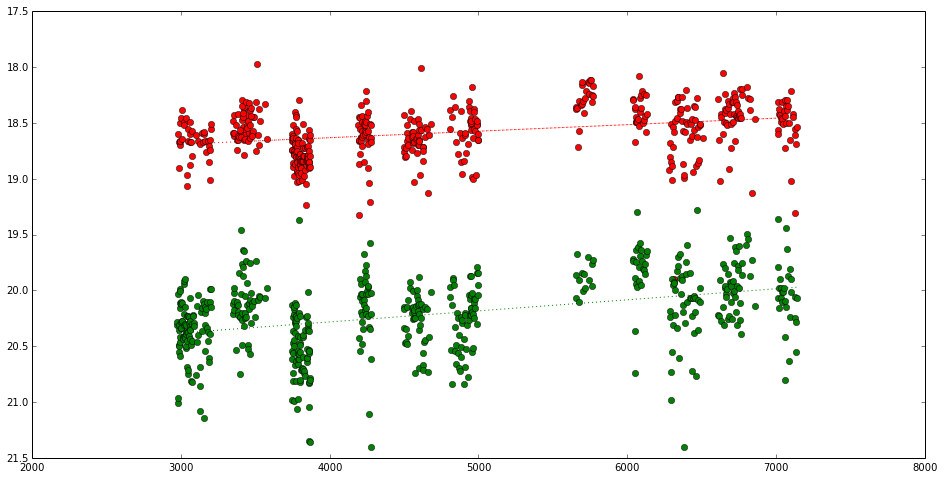

In [60]:
Vjd=NMVcal.drop(Vthrowout+NMVcal[NMVcal.NMcal < 19].index+NMVcal[NMVcal.NMcal > 21.5].index).dropna(how='any').juliandate
Vmag=NMVcal.drop(Vthrowout+NMVcal[NMVcal.NMcal < 19].index+NMVcal[NMVcal.NMcal > 21.5].index).dropna(how='any').NMcal
Ijd=NMIcal.drop(Ithrowout+NMIcal[NMIcal.NMcal < 17].index).dropna(how='any').juliandate
Imag=NMIcal.drop(Ithrowout+NMIcal[NMIcal.NMcal < 17].index).dropna(how='any').NMcal

regVmag=linear_model.LinearRegression()
regImag=linear_model.LinearRegression()

#now we trian the model on our data sets. we have to drop any NaNs, or else the regression algorithm wont work
regVmag.fit(Vjd.values.reshape(-1,1)
            ,Vmag.values.reshape(-1,1))
regImag.fit(Ijd.values.reshape(-1,1),
            Imag.values.reshape(-1,1))

fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

#and also plot the model, using the observation dates as inputs
ax.plot(Vjd.values.reshape(-1,1).astype(float)-2450000,
        regVmag.predict(Vjd.values.reshape(-1,1).astype(float)),color='green',linestyle=':')

ax.plot(Ijd.values.reshape(-1,1).astype(float)-2450000,
        regImag.predict(Ijd.values.reshape(-1,1).astype(float)),color='red',linestyle=':')

ax.plot(Ijd-2450000, Imag, 'ro')
ax.plot(Vjd-2450000, Vmag, 'go')

ax.invert_yaxis()


In [61]:
print regVmag.coef_*365, regImag.coef_*365

[[-0.03613517]] [[-0.02130972]]


In [55]:
#this is the data I'm giving to Jeff McClintok
NMVcal.drop(Vthrowout+NMVcal[NMVcal.NMcal < 19].index+NMVcal[NMVcal.NMcal > 21.5].index).dropna(how='any').drop('Unnamed: 0', axis=1).ix[:,['date','juliandate','std','NMcal']].to_csv('NovaMuscaVband_McClintock')

In [56]:
NMIcal.drop(Ithrowout+NMIcal[NMIcal.NMcal < 17].index).dropna(how='any').ix[:,['date','juliandate','std','NMcal']].to_csv('NovaMuscaIband_McClintock')

In [62]:
Ithrowout+NMIcal[NMIcal.NMcal < 17].index

Int64Index([246, 271, 272, 278, 280, 301, 421, 422, 423, 479], dtype='int64')

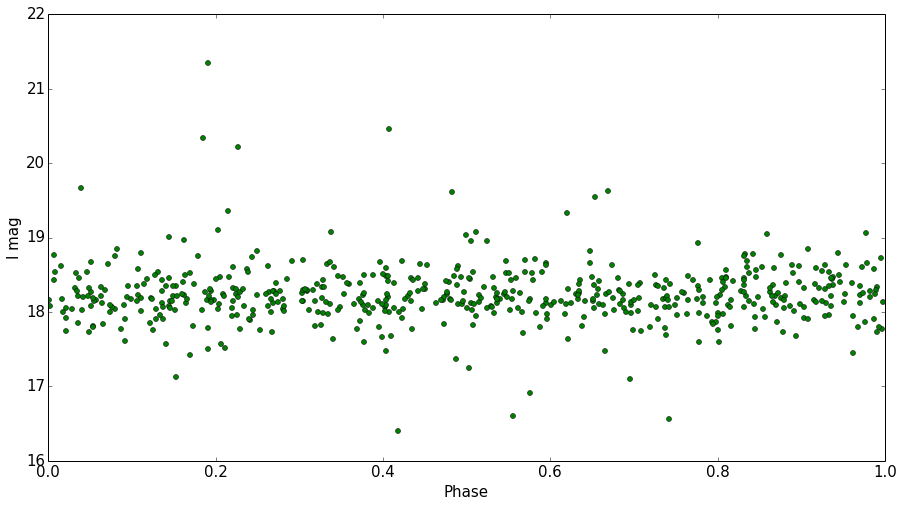

In [26]:
fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

t=.4326

ax.plot((NovaMuscaModelI['juliandate'].values.astype(float)%t)/(t),
        NovaMuscaModelI['NMcal'],'ro',ms=5)

ax.set_xlabel('Phase')
ax.set_ylabel('I mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)
    
plt.show()

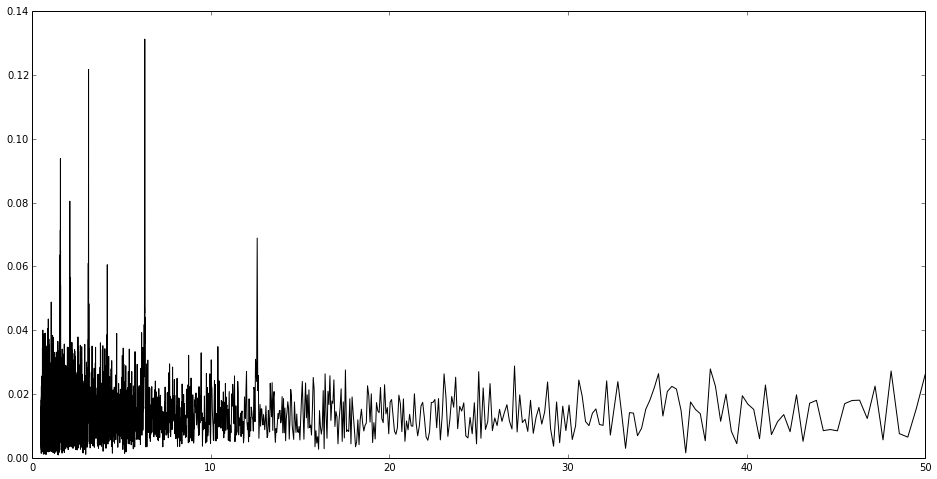

In [11]:
from astroML.time_series import multiterm_periodogram
days = np.linspace(.02, 2, 10000)
omega = 1/days

#compute lobm-scargle ps
PS=multiterm_periodogram(NovaMuscaModelI['juliandate'].values,NovaMuscaModelI['mag1']-NovaMuscaModelI['offset']
                         ,np.ones(len(NovaMuscaModelI))*.05 , omega, n_terms=4)
    
    
#create quick plot of power spectra
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(111)
ax1.plot(omega, PS, '-', c='black', lw=1, zorder=1)
#ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
#ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')
plt.show()
truncF=pd.DataFrame({"PS":PS, "omega":omega, "period":2*np.pi/omega})

In [16]:
truncF.sort(columns='PS', ascending=False)[:20]

,PS,omega,period
701,0.131310,6.296758,0.997844
1503,0.121784,3.148379,1.995689
3107,0.093900,1.574190,3.991378
3112,0.093095,1.571740,3.997599
1504,0.091914,3.146417,1.996933
2305,0.080487,2.098919,2.993533
1501,0.077311,3.152310,1.993201
3113,0.072714,1.571251,3.998843
3116,0.071400,1.569786,4.002576
1506,0.070410,3.142502,1.999422


In [345]:
(NovaMuscaModelI['NMcal']).describe()

count    570.000000
mean      18.230001
std        0.384028
min       16.396250
25%       18.055625
50%       18.199277
75%       18.410375
max       20.465125
Name: NMcal, dtype: float64

In [342]:
(NovaMuscaModelV['NMcal']).describe()

count    563.000000
mean      20.199946
std        0.357048
min       18.493000
25%       19.982500
50%       20.187833
75%       20.405833
max       21.399833
Name: NMcal, dtype: float64

In [319]:
VI=pd.merge(NovaMuscaModelV, NovaMuscaModelI, on='date')

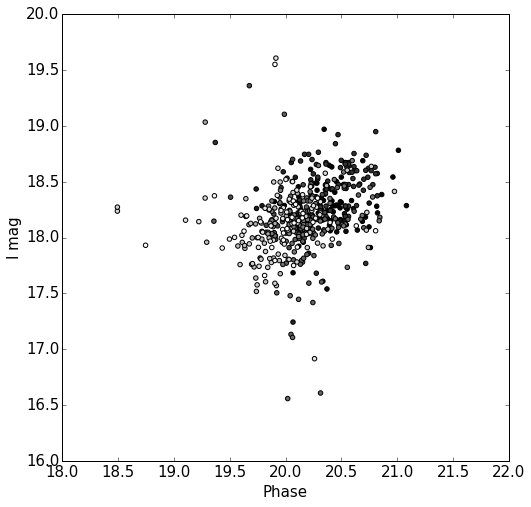

In [335]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)


plt.scatter(VI['NMcal_x'],VI['NMcal_y'],c=VI['juliandate_x'].astype('float'), cmap='gray')

ax.set_xlabel('Phase')
ax.set_ylabel('I mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)
ax.set_xlim([18.0,22])
    
plt.show()

In [380]:
photVTable['merr1'].describe()

count    575.000000
mean       0.102085
std        0.102591
min        0.001000
25%        0.055000
50%        0.074000
75%        0.114500
max        1.270000
Name: merr1, dtype: float64